# Distributed Algorithms with Dask: K-Means||

Group members:
- Franco Aquistapace
- Hooman Sabzi
- Daize Li

## Imports and configuration

In [1]:
# Import Dask
import dask

In [2]:
# Set up Dask configuration:
# Retries for connections
dask.config.set({'distributed.comm.retry.count': 5, 
                 'distributed.worker.use-file-locking': False, 
                 'distributed.worker.transfer.message-bytes-limit': '200MB',
                 'distributed.scheduler.worker-ttl': None})

In [3]:
# Import libraries
# Dask
from dask.distributed import Client, SSHCluster, progress, LocalCluster
import dask.array as da
import dask.dataframe as dd
# Others
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_rcv1, fetch_kddcup99

In [4]:
def open_cluster():
    cluster = SSHCluster(
        ["10.67.22.240", "10.67.22.240", "10.67.22.17", "10.67.22.100", "10.67.22.126"],
        connect_options={"known_hosts": None},
        worker_options={"nthreads": 1, "memory_limit": "2GB"},
        scheduler_options={"port": 0, "dashboard_address": ":8787"}
    )
    client = Client(cluster)
    return cluster, client

In [5]:
def close_cluster(cluster, client):
    cluster.close()
    client.close()

## Developing the K-means|| algorithm

### Auxiliary functions

One important function here is the cost:

$$\phi_X(C) = \sum_{x\in X} d^2(x, C) = \sum_{x\in X} \min_{i=1,..., k}||x-c_i||^2$$

Notice that:

$$||x-y||^2 = \sum_j (x_j - y_j)^2 = \sum_j x_j^2 - 2x_j y_j + y_j^2$$

Then, for $x_n\in\{x_1, x_2, ..., x_{|X|}\}$ and $c_m\in{c_1, c_2, ..., c_{|C|}}$, we can define the squared distance matrix $D^2\in\mathbb{R}^{|X|\times |C|}$ as:

$$D^2_{nm} = ||x_n-c_m||^2 = \sum_j x_{nj}^2 - 2x_{nj} c_{mj} + c_{mj}^2$$

$$D^2_{nm} = \sum_j x_{nj}x^T_{jn} - 2\sum_j x_{nj} c^T_{jm} + \sum_j c_{mj}c^T_{jm} = (XX^T)_{nn} - 2 (XC^T)_{nm} + (CC^T)_{mm}$$

Furthermore, notice that if the data $X$ is fixed, then the matrix $(XX^T)$ is constant and does not depend on the choice of centroids $C$. Therefore, we may calculate the vector $(XX^T)_{nn}$ at the beggining of the process and store it so that we don't need to recalculate it every time we want to estimate the cost function.

In [6]:
def get_first_sample(data_path):
    '''
    Params:
        data_path : str
            Path to a given data file.
    Output:
        Returns the first row of the given data.
    '''
    # Read only first row using pandas
    return pd.read_csv(data_path, nrows=1)


def get_XXT_term(X):
    '''
    Params:
        X : Dask array or dataframe
            Array containing data points.
    Output:
        Returns the self multiplication term from the
        squared distance matrix formula.
    '''
    # Turn into array
    X_da = da.array(X)
    # Get diagonal of X*X_T
    XXT = da.einsum('ij,ij -> i', X_da, X_da)
    return XXT


def partial_squared_dist_matrix(C, X):
    '''
    Params:
        C : Dask array or dataframe
            Array containing centroid locations
        X : Dask array or dataframe
            Array containing data points.
    Output:
        Returns the partial squared distance matrix, 
        evaluated over the set of points X with respect 
        to the centroids C. The partial matrix is defined
        as:
         D'^2 = 2*XC^T + CC^T
    '''
    # Turn into arrays
    X_da = da.array(X)
    
    # Calculate XC term
    XC_term = da.einsum('nj, mj -> nm', X_da, C)

    # Calculate CC term
    CC_term = da.einsum('ij,ij -> i', C, C)
    
    return -2*XC_term + CC_term
    

def cost_function(C, X, XXT):
    '''
    Params:
        C : Dask array or dataframe
            Array containing centroid locations
        X : Dask array or dataframe
            Array containing data points.
        XXT : Dask array or dataframe
            Array with same number of rows as X, 
            containing the X*X^T term of the
            squared distance matrix.
    Output:
        Returns the K-means cost function, evaluated
        over the set of points X with respect to the
        centroids C.
    '''
    # First, get partial squared distances
    D2 = partial_squared_dist_matrix(C, X)

    # Minimize over C axis and sum
    D2_min_sum = da.sum(da.min(D2, axis=1))

    # Add to XXT sum and return
    return da.sum(XXT) + D2_min_sum


def sample_new_centroids(C, X, XXT, phi, l):
    '''
    Params:
        C : Dask array or dataframe
            Array containing centroid locations
        X : Dask array or dataframe
            Array containing data points.
        XXT : Dask array or dataframe
            Array with same number of rows as X, 
            containing the X*X^T term of the
            squared distance matrix.
        phi : float
            Current cost function for the data X
            and the centroids C.
        l : float or int
            Oversampling factor, must be greater 
            than zero.
    Output:
        Returns new centroids from X, sampled with
        probability:
             p_x = l * D^2 / phi
        where D^2 is the squared distance from x to
        C and phi is the current cost function.
    '''
    # Get D^2
    partial_D_sq = partial_squared_dist_matrix(C, X)
    D_sq = da.add(XXT, da.min(partial_D_sq, axis=1))

    # Get sampling probabilities
    p_X = (l * D_sq / phi).compute_chunk_sizes()
    
    # Draw random numbers between 0 and 1
    rand_nums = da.random.uniform(size=p_X.shape)

    # Get new centroid indexes
    C_prime_idx = rand_nums < p_X

    # Gather new centroids from the data
    if isinstance(X, dd.DataFrame):
        C_prime = X.loc[C_prime_idx]
    else:
        C_prime = X[C_prime_idx]
    return C_prime

def get_cluster_classification(C, X, XXT):
    '''
    Params:
        C : Dask array or dataframe
            Array containing centroid locations
        X : Dask array or dataframe
            Array containing data points.
    Output:
        Returns the corresponding centroid in C
        for each sample in X.
    '''
    # Get partial squared distances
    partial_D_sq = partial_squared_dist_matrix(C, X)

    # Select the correct centroid from arg min
    C_ids = da.argmin(partial_D_sq, axis=1)
    return C_ids

def get_centroid_weights(labels):
    '''
    Params:
        labels : array
            Set of labels indicating the centroid of
            each data point.
    Output:
        Returns the weight of each centroid, defined 
        as the number of samples in the data closer
        to that centroid than to any other centroid.
    '''
    unique_labels, counts = da.unique(da.array(labels), return_counts=True)
    return unique_labels, counts


def compute_centroids(X, weights, labels, dims):
    '''
    Params:
        X : array
            Array containing data points.
        weights : array
            Weight for each data point.
        labels : array
            Set of labels indicating the cluster of
            each data point.
        dims : int
            Number of dimensions of the given data.
    Output:
        Returns the centroids for the given data and
        the given partition.
    '''    
    # Turn data into Dask array
    X = da.array(X)
    weights = da.array(weights)
    
    # Get unique labels
    unique_l = da.unique(da.array(labels)).compute_chunk_sizes()

    # Init new centroids
    C = da.array(np.zeros(shape=(len(unique_l), dims)))

    # Operate for each unique cluster
    for i, idx in enumerate(unique_l):
        # Get data
        C_data = X[labels == idx, :].compute_chunk_sizes()
        data_weights = weights[labels == idx].compute_chunk_sizes()

        # Calculate weighted mean as new centroid
        new_C = da.average(C_data, axis=0, weights=data_weights)

        # Store new centroid
        C[i,:] += new_C
        
    return C


# Complete k-means pipeline
def k_means_parallel(path, k, l, random_seed=None, label_column=None,
                     datatype='dataframe', npartitions=1, chunk_size=1000,
                     verbose=2, data=None):
    '''
    Params:
        path : str
            Path to the file containing the input data. If "rcv1", then
            the RCV1 dataset is downloaded inside the function.
        k : int
            Number of clusters to use.
        l : int or float
            Oversampling factor for the K-means|| initialization method.
        random_seed : int (optional)
            Seed for the random number generators. Not used by default.
        label_column : str (optional)
            Name of the column containing the labels of the data. Not
            used by default.
        datatype : str (optional)
            Either "dataframe" (default) or "array". Indicates how to
            process the input data.
        npartitions : int (optional)
            Number of partitions to use if the data is processed as a
            dataframe. Default is 1.
        chunk_size : int (optional)
            Chunk size to use if the data is processed as an array.
            Default is 1000.
        verbose : int (optional)
            Amount of information to print. If 0, no information is 
            printed. If 1, only timing information is printed. If 2
            (default), all information is printed.
        data : array (optional)
            Predefned data to run the algorithm on. If given, then path
            is ignored. Not used by default.
    Output:
        Returns a dictionary with the following elements:
            - centroids : array       -> Centroid positions
            - cluster_labels : array  -> Cluster assignments
            - timing : dict           -> Performance information
    '''
    # Begin overall timing
    t1 = time.time()
    
    # Initialize random number generator from Dask and numpy seed
    if random_seed != None:
        rng = da.random.default_rng(random_seed)
        np.random.seed(random_seed)

    # Read input data (if not given)
    t_data = time.time()
    if type(data) == type(None):
        pre_data = False
        if verbose == 2:
            print('Reading input data')
    
        if path not in ['rcv1']:
            data = pd.read_csv(path)
            data_shape = data.shape
            
        elif path == 'rcv1':
            # Load RCV1 dataset
            rcv1 = fetch_rcv1()
            data = rcv1.data
            data_shape = data.shape
    else:
        pre_data = True
        data_shape = data.shape
    dt_data = time.time() - t_data

    # Separate labels from input
    t_data_process = time.time()
    if label_column != None:
        # Input
        X_width = data_shape[1]-1
        X = data.drop(columns=[label_column])
        X = dd.from_pandas(X, npartitions=npartitions)
        X = X.persist()  # split
        client.rebalance(X)  # spread around all of your workers
        
    else:
        # Only input
        X_width = data_shape[1]
        X = data
        X = dd.from_pandas(X, npartitions=npartitions)
        X = X.persist()  # split
        client.rebalance(X)  # spread around all of your workers
        
    dt_data_process = time.time() - t_data_process
    if verbose > 0:
        print(f'Data loaded and processed in {round(dt_data_process + dt_data, 1)} s')

    # Run the K-means algorithm:
    # Get first sample as initial centroid
    t_first_centroid = time.time()
    if path not in ['rcv1']:
        if pre_data:
            first_sample = np.array(X[0,:])
        else:
            first_sample = get_first_sample(path)
    elif path == 'rcv1':
        first_sample = data[0,:].toarray()
        
    if label_column != None:
        first_sample = first_sample.drop(columns=[label_column])
    C = da.array([np.array(first_sample).flatten()])

    dt_first_centroid = time.time() - t_first_centroid
    
    # Calculate constant XXT term, 
    # also persist since we are going to reuse it 
    t_xxt = time.time()
    XXT = get_XXT_term(X).persist()
    dt_xxt = time.time() - t_xxt
    
    # Get initial cost function
    t_phi_init = time.time()
    phi_init = cost_function(C, X, XXT).compute()
    dt_phi_init = time.time() - t_phi_init
    
    # Get number of iterations of the || algorithm
    O_log_phi = round(np.log(phi_init))
    
    # Init current cost
    phi = phi_init.copy()

    # Proceed with main || loop
    t_parallel_init = time.time()
    if verbose == 2:
        print('\nRunning K-means|| initialization:')
    for i in range(O_log_phi):
        if verbose == 2:
            print(f'Iteration {i+1} of {O_log_phi}')
            
        # Sample new centroids
        C_prime = sample_new_centroids(C, X, XXT, phi, l)
    
        # Add to the current centroids
        C = da.vstack([C, C_prime]).compute()
    
        # Calculate new cost and update current
        phi = cost_function(C, X, XXT).compute()
    
    if verbose == 2:
        # Print number of final centroids from ||
        print('\nNumber of initialized centroids:', C.shape[0])
        
        # Print initial vs. final cost
        print('Cost before initialization:', phi_init)
        print('Cost after initialization:', phi)

    dt_parallel_init = time.time() - t_parallel_init
    if verbose > 0:
        print(f'K-means|| initialization finished in {round(dt_parallel_init, 1)} s')
    
    # Get the weight of each centroid
    if verbose == 2:
        print('\nCalculating centroid weights')
    t_weight_calc = time.time()
    X_labels = get_cluster_classification(C, X, XXT).compute_chunk_sizes()
    used_C, w_C = get_centroid_weights(X_labels)
    used_C = used_C.compute()
    w_C = w_C.compute()

    dt_weight_calc = time.time() - t_weight_calc
    if verbose > 0:
        print(f'Centroid weight calculation finished in {round(dt_weight_calc, 1)} s')

    # Proceed with Lloyd's algorithm on the centroids
    t_lloyd = time.time()
    if verbose == 2:
        print('\nClustering centroids')
    
    # Initialize k final centroids, as the k-th heaviest
    # centroids from the previous step
    C_f = C[np.isin(w_C, np.sort(w_C, )[len(w_C)-k:])]
    
    # Calculate XXT for centroids
    CCT =  get_XXT_term(C).persist()
    
    # Perform iterative adjustments
    lloyd_done = False
    N_lloyd_steps = 0
    while not lloyd_done:
        # Save old labels (after first iteration)
        if N_lloyd_steps > 0:
            old_labels = C_labels.copy()
        
        # Calculate current clustering
        C_labels = get_cluster_classification(C_f, C, CCT).persist()
    
        # Compute new centroids from mean within clusters
        C_f = compute_centroids(C, w_C, C_labels, X_width).compute()
        
        # Check for termination condition (after first iteration)
        if N_lloyd_steps > 0:
            different_labels = da.sum(old_labels != C_labels).compute()
            if different_labels == 0:
                lloyd_done = True
    
        # Increase step counter
        N_lloyd_steps += 1
    dt_lloyd = time.time() - t_lloyd
    
    if verbose == 2:
        print(f'Centroid clustering finished after {N_lloyd_steps} iterations and {round(dt_lloyd)} s')
    elif verbose == 1:
        print(f'\nLloyd algorithm finished in {round(dt_lloyd)} s')
    
    # Compute final labels
    if verbose == 2:
        print('\nCalculating final labels')
    t_final_labels = time.time()
    final_labels = get_cluster_classification(C_f, X, XXT).compute()
    dt_final_labels = time.time() - t_final_labels
    if verbose > 0:
        print(f'Final labels calculated in {round(dt_final_labels)} s')

    # Finish timing
    dt_total = time.time() - t1
    if verbose > 0:
        print(f'\nProcess finished in {round(dt_total, 1)} s')

    # Build performance info
    timing = {'total': dt_total,
              'data_input': dt_data,
              'data_processing': dt_data_process,
              'first_centroid': dt_first_centroid,
              'xxt': dt_xxt,
              'phi_init': dt_phi_init, 
              'parallel_init': dt_parallel_init, 
              'weight_calc': dt_weight_calc, 
              'lloyd' : dt_lloyd, 
              'final_labels': dt_final_labels}
    
    # Gather output info into a dict and return
    output_info = {'centroids': C_f,
                   'cluster_labels': final_labels,
                   'timing': timing}
    return output_info

## Qualitative test of the algorithm

We first test the algorithm qualitatively by applying it to a small synthetic dataset, generated by sampling from a mixture of three Gaussian distributions.

In [7]:
# Initialize the client
cluster, client = open_cluster()

2025-07-07 15:34:23,965 - distributed.deploy.ssh - INFO - 2025-07-07 15:34:23,965 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 15:34:23,997 - distributed.deploy.ssh - INFO - 2025-07-07 15:34:23,995 - distributed.scheduler - INFO - State start
2025-07-07 15:34:24,003 - distributed.deploy.ssh - INFO - 2025-07-07 15:34:24,003 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:45749
2025-07-07 15:34:25,485 - distributed.deploy.ssh - INFO - 2025-07-07 15:34:25,484 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:33851'
2025-07-07 15:34:25,920 - distributed.deploy.ssh - INFO - 2025-07-07 15:34:25,919 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.240:35973
2025-07-07 15:34:26,143 - distributed.deploy.ssh - INFO - 2025-07-07 15:34:26,141 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.12

In [8]:
# Testing on our curstom data:
# Script parameters
RANDOM_SEED = 42
INPUT_DATA = './testing_data.csv'
LABEL_COLUMN = 'label'
NPARTITIONS = 1
K = 3 # Number of clusters
L = 3 # Oversampling factor
VERBOSE = 2 # Amount of information to print out (0: Nothing, 1: Only timings, 2: All information)
path_git = 'https://media.githubusercontent.com/media/FrancoAquistapace/Parallel_kmeans_with_Dask/refs/heads/main/testing_data.csv'

# Run k-means
test_res = k_means_parallel(path_git, K, L, random_seed=RANDOM_SEED, label_column=LABEL_COLUMN,
                     datatype='dataframe', npartitions=NPARTITIONS, verbose=VERBOSE)

Reading input data
Data loaded and processed in 0.4 s

Running K-means|| initialization:
Iteration 1 of 11
Iteration 2 of 11
Iteration 3 of 11
Iteration 4 of 11
Iteration 5 of 11
Iteration 6 of 11
Iteration 7 of 11
Iteration 8 of 11
Iteration 9 of 11
Iteration 10 of 11
Iteration 11 of 11

Number of initialized centroids: 32
Cost before initialization: 40052.0458284903
Cost after initialization: 1047.5108424417012
K-means|| initialization finished in 2.8 s

Calculating centroid weights
Centroid weight calculation finished in 0.2 s

Clustering centroids
Centroid clustering finished after 3 iterations and 1 s

Calculating final labels
Final labels calculated in 0 s

Process finished in 5.9 s


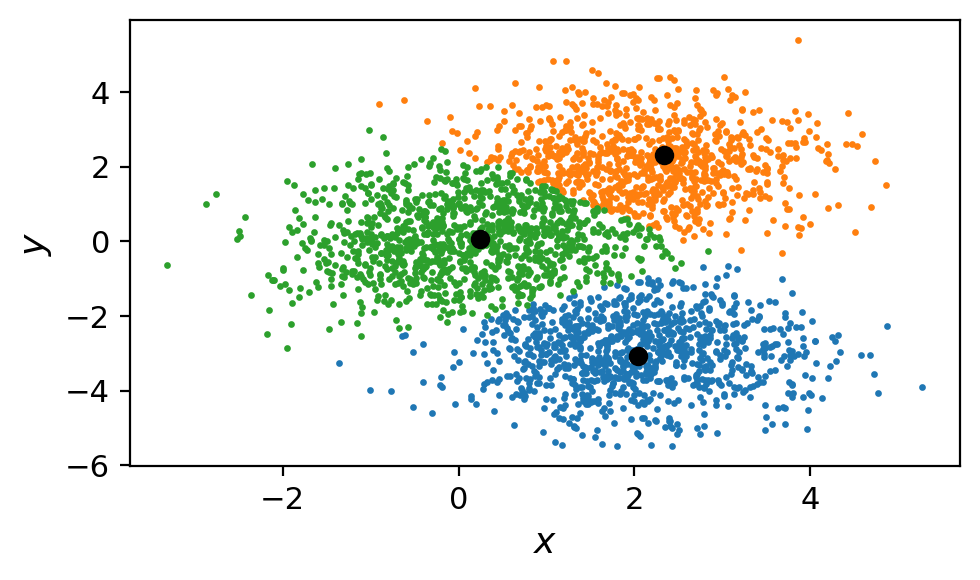

In [9]:
# Let's plot the data, and the positions of the centroids:
# Figure params
FONTSIZE = 13
S = 2

# Init figure
fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=200)

# Plot clustered data
cluster_labels = test_res['cluster_labels']
test_data = pd.read_csv(path_git)
for i in range(K):
    k_data = test_data.loc[cluster_labels == i]
    plt.scatter(k_data['x'], k_data['y'], s=S)

# Plot centroids
test_centroids = test_res['centroids']
plt.scatter(test_centroids[:,0], test_centroids[:,1], c='k')

# Labels
plt.xlabel(r'$x$', fontsize=FONTSIZE)
plt.ylabel(r'$y$', fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE-2)

# Show
plt.tight_layout()
plt.show();

The algorithm appears to be working as intended.

In [10]:
close_cluster(cluster, client)

## Benchmarking

### Finding optimal number of partitions

In [11]:
# Data parameters
N_SAMPLES = int(1e5)
N_FEATURES = 50
CENTERS = 5
RS = 42
LABEL_COLUMN = 'label'
L = 3 # Oversampling factor

In [12]:
path_git = 'https://media.githubusercontent.com/media/FrancoAquistapace/Parallel_kmeans_with_Dask/refs/heads/main/test_blobs_50dim_5c_1e5.csv'

#### 4 partitions

In [30]:
time_res = []
for i in range(5):
    # Open cluster
    cluster, client = open_cluster()
    time.sleep(2)

    # Run algorithm
    N_PARTITIONS = 4
    res = k_means_parallel(path=path_git, k=CENTERS, l=L, label_column=LABEL_COLUMN,
                           random_seed=RS, verbose=0, npartitions=N_PARTITIONS)
    algorithm_time = res['timing']['total'] - res['timing']['data_input']
    time_res.append(algorithm_time)
    time.sleep(2)
    
    # Close cluster
    close_cluster(cluster, client)
    time.sleep(2)

2025-07-06 15:26:31,743 - distributed.deploy.ssh - INFO - 2025-07-06 15:26:31,740 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 15:26:31,772 - distributed.deploy.ssh - INFO - 2025-07-06 15:26:31,770 - distributed.scheduler - INFO - State start
2025-07-06 15:26:31,776 - distributed.deploy.ssh - INFO - 2025-07-06 15:26:31,775 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:43673
2025-07-06 15:26:33,208 - distributed.deploy.ssh - INFO - 2025-07-06 15:26:33,208 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:36699'
2025-07-06 15:26:33,558 - distributed.deploy.ssh - INFO - 2025-07-06 15:26:33,560 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:33951'
2025-07-06 15:26:33,574 - distributed.deploy.ssh - INFO - 2025-07-06 15:26:33,573 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

In [33]:
print('Mean algorithm time with 4 partitions:')
print(f'{round(np.mean(time_res), 2)} ± {round(np.std(time_res), 2)} s')

Mean algorithm time with 4 partitions:
12.88 ± 0.74 s


#### 8 partitions

In [34]:
time_res = []
for i in range(5):
    # Open cluster
    cluster, client = open_cluster()
    time.sleep(2)

    # Run algorithm
    N_PARTITIONS = 8
    res = k_means_parallel(path=path_git, k=CENTERS, l=L, label_column=LABEL_COLUMN,
                           random_seed=RS, verbose=0, npartitions=N_PARTITIONS)
    algorithm_time = res['timing']['total'] - res['timing']['data_input']
    time_res.append(algorithm_time)
    time.sleep(2)
    
    # Close cluster
    close_cluster(cluster, client)
    time.sleep(2)

2025-07-06 15:30:19,489 - distributed.deploy.ssh - INFO - 2025-07-06 15:30:19,487 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 15:30:19,516 - distributed.deploy.ssh - INFO - 2025-07-06 15:30:19,515 - distributed.scheduler - INFO - State start
2025-07-06 15:30:19,520 - distributed.deploy.ssh - INFO - 2025-07-06 15:30:19,519 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:43499
2025-07-06 15:30:21,030 - distributed.deploy.ssh - INFO - 2025-07-06 15:30:21,028 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:44889'
2025-07-06 15:30:21,380 - distributed.deploy.ssh - INFO - 2025-07-06 15:30:21,382 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:36771'
2025-07-06 15:30:21,386 - distributed.deploy.ssh - INFO - 2025-07-06 15:30:21,387 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.12

In [73]:
print('Mean algorithm time with 8 partitions:')
print(f'{round(np.mean(time_res), 2)} ± {round(np.std(time_res), 2)} s')

Mean algorithm time with 8 partitions:
14.76 ± 0.85 s


### Time distribution

In [11]:
# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

N_runs = 10
for i in range(N_runs):
    print(f'Iteration {i+1} of {N_runs}')
    # Open cluster
    cluster, client = open_cluster()
    time.sleep(2)

    # Run algorithm
    N_PARTITIONS = 4
    res = k_means_parallel(path=path_git, k=CENTERS, l=L, label_column=LABEL_COLUMN,
                           random_seed=RS, verbose=0, npartitions=N_PARTITIONS)

    # Save results
    for k in stats:
        stats[k].append(res['timing'][k])
    
    time.sleep(1)
    
    # Close cluster
    close_cluster(cluster, client)
    time.sleep(2)

stats = pd.DataFrame(stats)
stats.to_csv('time_dist_stats.csv', index=False)

Iteration 1 of 10


2025-07-04 17:18:32,129 - distributed.deploy.ssh - INFO - 2025-07-04 17:18:32,127 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:18:32,156 - distributed.deploy.ssh - INFO - 2025-07-04 17:18:32,156 - distributed.scheduler - INFO - State start
2025-07-04 17:18:32,160 - distributed.deploy.ssh - INFO - 2025-07-04 17:18:32,160 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:37141
2025-07-04 17:18:33,583 - distributed.deploy.ssh - INFO - 2025-07-04 17:18:33,582 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:39233'
2025-07-04 17:18:33,937 - distributed.deploy.ssh - INFO - 2025-07-04 17:18:33,933 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:44431'
2025-07-04 17:18:33,948 - distributed.deploy.ssh - INFO - 2025-07-04 17:18:33,946 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

Iteration 2 of 10


2025-07-04 17:19:21,108 - distributed.deploy.ssh - INFO - 2025-07-04 17:19:21,106 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:19:21,136 - distributed.deploy.ssh - INFO - 2025-07-04 17:19:21,134 - distributed.scheduler - INFO - State start
2025-07-04 17:19:21,139 - distributed.deploy.ssh - INFO - 2025-07-04 17:19:21,139 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:42127
2025-07-04 17:19:22,541 - distributed.deploy.ssh - INFO - 2025-07-04 17:19:22,538 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:36567'
2025-07-04 17:19:22,551 - distributed.deploy.ssh - INFO - 2025-07-04 17:19:22,548 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:45649'
2025-07-04 17:19:22,563 - distributed.deploy.ssh - INFO - 2025-07-04 17:19:22,564 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 3 of 10


2025-07-04 17:20:04,229 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:04,227 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:20:04,256 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:04,256 - distributed.scheduler - INFO - State start
2025-07-04 17:20:04,260 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:04,260 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:45365
2025-07-04 17:20:05,682 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:05,680 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:35043'
2025-07-04 17:20:05,880 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:05,876 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:38471'
2025-07-04 17:20:05,897 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:05,898 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 4 of 10


2025-07-04 17:20:43,744 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:43,743 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:20:43,772 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:43,772 - distributed.scheduler - INFO - State start
2025-07-04 17:20:43,776 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:43,776 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:42795
2025-07-04 17:20:45,204 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:45,200 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:37601'
2025-07-04 17:20:45,214 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:45,212 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:43449'
2025-07-04 17:20:45,221 - distributed.deploy.ssh - INFO - 2025-07-04 17:20:45,222 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 5 of 10


2025-07-04 17:21:06,683 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:06,681 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:21:06,710 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:06,709 - distributed.scheduler - INFO - State start
2025-07-04 17:21:06,714 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:06,713 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38577
2025-07-04 17:21:08,167 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:08,165 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:36909'
2025-07-04 17:21:08,350 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:08,347 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:38141'
2025-07-04 17:21:08,358 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:08,356 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

Iteration 6 of 10


2025-07-04 17:21:33,463 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:33,462 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:21:33,493 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:33,491 - distributed.scheduler - INFO - State start
2025-07-04 17:21:33,496 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:33,496 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:33045
2025-07-04 17:21:34,899 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:34,896 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:33931'
2025-07-04 17:21:34,905 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:34,903 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:37021'
2025-07-04 17:21:34,911 - distributed.deploy.ssh - INFO - 2025-07-04 17:21:34,912 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 7 of 10


2025-07-04 17:22:17,798 - distributed.deploy.ssh - INFO - 2025-07-04 17:22:17,797 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:22:17,826 - distributed.deploy.ssh - INFO - 2025-07-04 17:22:17,825 - distributed.scheduler - INFO - State start
2025-07-04 17:22:17,831 - distributed.deploy.ssh - INFO - 2025-07-04 17:22:17,830 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:37781
2025-07-04 17:22:19,256 - distributed.deploy.ssh - INFO - 2025-07-04 17:22:19,255 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:40597'
2025-07-04 17:22:19,462 - distributed.deploy.ssh - INFO - 2025-07-04 17:22:19,459 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:46561'
2025-07-04 17:22:19,468 - distributed.deploy.ssh - INFO - 2025-07-04 17:22:19,466 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

Iteration 8 of 10


2025-07-04 17:23:06,703 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:06,702 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:23:06,732 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:06,731 - distributed.scheduler - INFO - State start
2025-07-04 17:23:06,736 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:06,736 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:40611
2025-07-04 17:23:08,131 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:08,129 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:44461'
2025-07-04 17:23:08,137 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:08,135 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:42599'
2025-07-04 17:23:08,146 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:08,146 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 9 of 10


2025-07-04 17:23:45,789 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:45,788 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:23:45,817 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:45,817 - distributed.scheduler - INFO - State start
2025-07-04 17:23:45,822 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:45,822 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:46419
2025-07-04 17:23:47,263 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:47,261 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:34073'
2025-07-04 17:23:47,456 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:47,454 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:41913'
2025-07-04 17:23:47,478 - distributed.deploy.ssh - INFO - 2025-07-04 17:23:47,478 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 10 of 10


2025-07-04 17:24:11,286 - distributed.deploy.ssh - INFO - 2025-07-04 17:24:11,284 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-04 17:24:11,315 - distributed.deploy.ssh - INFO - 2025-07-04 17:24:11,313 - distributed.scheduler - INFO - State start
2025-07-04 17:24:11,319 - distributed.deploy.ssh - INFO - 2025-07-04 17:24:11,318 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:44231
2025-07-04 17:24:12,723 - distributed.deploy.ssh - INFO - 2025-07-04 17:24:12,722 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:37245'
2025-07-04 17:24:12,730 - distributed.deploy.ssh - INFO - 2025-07-04 17:24:12,729 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126:33051'
2025-07-04 17:24:12,732 - distributed.deploy.ssh - INFO - 2025-07-04 17:24:12,729 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

In [13]:
# Read our data
stats = pd.read_csv('time_dist_stats.csv')

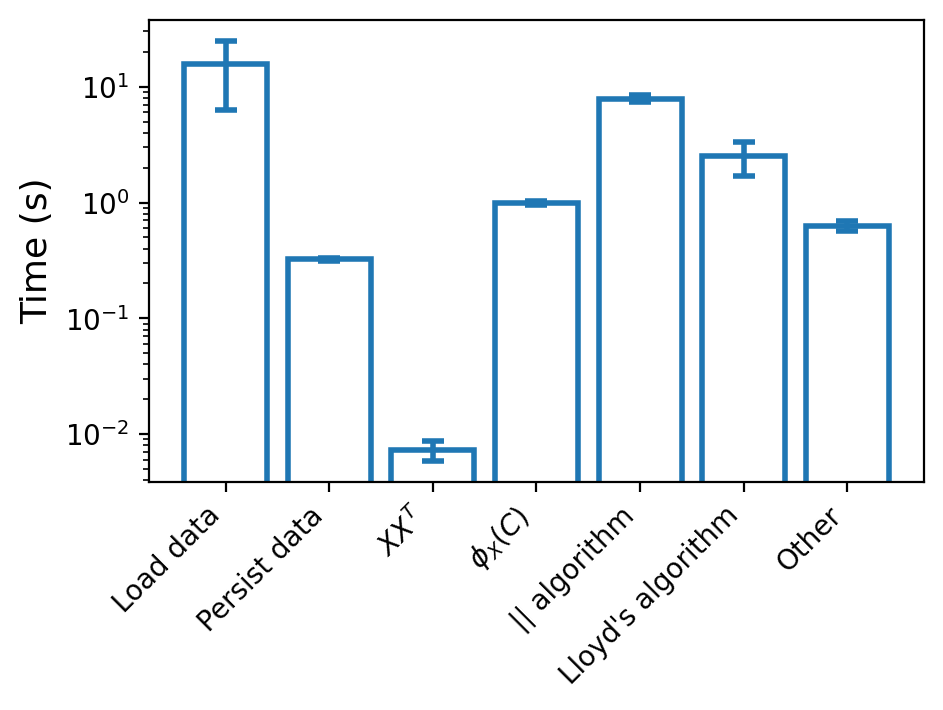

In [14]:
# Let's make a bar plot with the most important timings
read_t = stats['data_input'] + stats['first_centroid']
processing_t = stats['data_processing']
xxt_t = stats['xxt']
cost_t = stats['phi_init']
other_t = stats['weight_calc'] + stats['final_labels']
init_t = stats['parallel_init']
lloyd_t = stats['lloyd']

# Get timing labels, mean and std
timing_labels = ['Load data', 'Persist data', r'$XX^T$', r'$\phi_X(C)$', '|| algorithm', 'Lloyd\'s algorithm', 'Other']
mean_timings = [np.mean(d) for d in [read_t, processing_t, xxt_t, cost_t, init_t, lloyd_t, other_t]]
std_timings = [np.std(d) for d in [read_t, processing_t, xxt_t, cost_t, init_t, lloyd_t, other_t]]

# Figure params
FONTSIZE = 13
CS = 4
LW = 2

# Init figure
fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=200)

# Plot bars
plt.bar(np.arange(len(mean_timings)), mean_timings, facecolor='w', 
        edgecolor='tab:blue', linewidth=LW)
# Plot errorbars
plt.errorbar(np.arange(len(mean_timings)), mean_timings, yerr=std_timings, 
            ls='', capsize=CS, linewidth=LW, capthick=LW)

# Labels
plt.xticks(np.arange(len(mean_timings)), timing_labels, rotation=45, horizontalalignment='right')
plt.ylabel(r'Time (s)', fontsize=FONTSIZE)

# Set axis scale
ax.set_yscale('log')

Loading the data is the most time-consuming task of the pipeline, followed by the K-Means|| initialization and Lloyd's algorithm. The time spent in the calculation of the $XX^T$ term does not appear to be significant. However, it can still be worthwhile to calculate it only once, as the memory cost of persisting the $XX^T$ term is much smaller than that of the original dataset for high-dimensional data.

## Weak scaling test

#### Pipeline

In [15]:
def open_cluster_n_workers(n):
    nodes = ["10.67.22.240", "10.67.22.17"]
    if n >= 2:
        nodes.append("10.67.22.240")
    if n >= 3:
        nodes.append("10.67.22.100")
    if n == 4:
        nodes.append("10.67.22.126")
    if n > 4:
        print("Error: maximum number of workers is 4.")
        return None, None

    # Open cluster
    cluster = SSHCluster(
        nodes,
        connect_options={"known_hosts": None},
        worker_options={"nthreads": 1, "memory_limit": "2GB"},
        scheduler_options={"port": 0, "dashboard_address": ":8787"}
    )
    client = Client(cluster)
    return cluster, client


def open_local_cluster():
    cluster = LocalCluster(n_workers=1)
    client = Client(cluster)
    return cluster, client

In [16]:
def k_means_weak_scaling(path, n, k, l, random_seed=None, label_column=None,
                     datatype='dataframe', npartitions=1, chunk_size=1000,
                     verbose=2, data=None):
    '''
    Params:
        path : str
            Path to the file containing the input data. If "rcv1", then
            the RCV1 dataset is downloaded inside the function.
        n : int
            Number of repeated times the data is loaded.
        k : int
            Number of clusters to use.
        l : int or float
            Oversampling factor for the K-means|| initialization method.
        random_seed : int (optional)
            Seed for the random number generators. Not used by default.
        label_column : str (optional)
            Name of the column containing the labels of the data. Not
            used by default.
        datatype : str (optional)
            Either "dataframe" (default) or "array". Indicates how to
            process the input data.
        npartitions : int (optional)
            Number of partitions to use if the data is processed as a
            dataframe. Default is 1.
        chunk_size : int (optional)
            Chunk size to use if the data is processed as an array.
            Default is 1000.
        verbose : int (optional)
            Amount of information to print. If 0, no information is 
            printed. If 1, only timing information is printed. If 2
            (default), all information is printed.
        data : array (optional)
            Predefned data to run the algorithm on. If given, then path
            is ignored. Not used by default.
    Output:
        Returns a dictionary with the following elements:
            - centroids : array       -> Centroid positions
            - cluster_labels : array  -> Cluster assignments
            - timing : dict           -> Performance information
    '''
    # Begin overall timing
    t1 = time.time()
    
    # Initialize random number generator from Dask and numpy seed
    if random_seed != None:
        rng = da.random.default_rng(random_seed)
        np.random.seed(random_seed)

    # Read input data (if not given)
    t_data = time.time()
    if type(data) == type(None):
        pre_data = False
        if verbose == 2:
            print('Reading input data')
    
        if path not in ['rcv1']:
            if n == 1:
                data = pd.read_csv(path)
            else:
                data_reps = []
                for i in range(n):
                    data_reps.append(pd.read_csv(path))
                data = pd.concat(data_reps)
                    
            data_shape = data.shape
            
        elif path == 'rcv1':
            # Load RCV1 dataset
            rcv1 = fetch_rcv1()
            data = rcv1.data
            data_shape = data.shape
    else:
        pre_data = True
        data_shape = data.shape
    dt_data = time.time() - t_data

    # Separate labels from input
    t_data_process = time.time()
    if label_column != None:
        # Input
        X_width = data_shape[1]-1
        X = data.drop(columns=[label_column])
        X = dd.from_pandas(X, npartitions=npartitions)
        X = X.persist()  # split
        client.rebalance(X)  # spread around all of your workers
        
    else:
        # Only input
        X_width = data_shape[1]
        X = data
        X = dd.from_pandas(X, npartitions=npartitions)
        X = X.persist()  # split
        client.rebalance(X)  # spread around all of your workers
        
    dt_data_process = time.time() - t_data_process
    if verbose > 0:
        print(f'Data loaded and processed in {round(dt_data_process + dt_data, 1)} s')

    # Run the K-means algorithm:
    # Get first sample as initial centroid
    t_first_centroid = time.time()
    if path not in ['rcv1']:
        if pre_data:
            first_sample = np.array(X[0,:])
        else:
            first_sample = get_first_sample(path)
    elif path == 'rcv1':
        first_sample = data[0,:].toarray()
        
    if label_column != None:
        first_sample = first_sample.drop(columns=[label_column])
    C = da.array([np.array(first_sample).flatten()])

    dt_first_centroid = time.time() - t_first_centroid
    
    # Calculate constant XXT term, 
    # also persist since we are going to reuse it 
    t_xxt = time.time()
    XXT = get_XXT_term(X).persist()
    dt_xxt = time.time() - t_xxt
    
    # Get initial cost function
    t_phi_init = time.time()
    phi_init = cost_function(C, X, XXT).compute()
    dt_phi_init = time.time() - t_phi_init
    
    # Get number of iterations of the || algorithm
    O_log_phi = round(np.log(phi_init))
    
    # Init current cost
    phi = phi_init.copy()

    # Proceed with main || loop
    t_parallel_init = time.time()
    if verbose == 2:
        print('\nRunning K-means|| initialization:')
    for i in range(O_log_phi):
        if verbose == 2:
            print(f'Iteration {i+1} of {O_log_phi}')
            
        # Sample new centroids
        C_prime = sample_new_centroids(C, X, XXT, phi, l)
    
        # Add to the current centroids
        C = da.vstack([C, C_prime]).compute()
    
        # Calculate new cost and update current
        phi = cost_function(C, X, XXT).compute()
    
    if verbose == 2:
        # Print number of final centroids from ||
        print('\nNumber of initialized centroids:', C.shape[0])
        
        # Print initial vs. final cost
        print('Cost before initialization:', phi_init)
        print('Cost after initialization:', phi)

    dt_parallel_init = time.time() - t_parallel_init
    if verbose > 0:
        print(f'K-means|| initialization finished in {round(dt_parallel_init, 1)} s')
    
    # Get the weight of each centroid
    if verbose == 2:
        print('\nCalculating centroid weights')
    t_weight_calc = time.time()
    X_labels = get_cluster_classification(C, X, XXT).compute_chunk_sizes()
    used_C, w_C = get_centroid_weights(X_labels)
    used_C = used_C.compute()
    w_C = w_C.compute()

    dt_weight_calc = time.time() - t_weight_calc
    if verbose > 0:
        print(f'Centroid weight calculation finished in {round(dt_weight_calc, 1)} s')

    # Proceed with Lloyd's algorithm on the centroids
    t_lloyd = time.time()
    if verbose == 2:
        print('\nClustering centroids')
    
    # Initialize k final centroids, as the k-th heaviest
    # centroids from the previous step
    C_f = C[np.isin(w_C, np.sort(w_C, )[len(w_C)-k:])]
    
    # Calculate XXT for centroids
    CCT =  get_XXT_term(C).persist()
    
    # Perform iterative adjustments
    lloyd_done = False
    N_lloyd_steps = 0
    while not lloyd_done:
        # Save old labels (after first iteration)
        if N_lloyd_steps > 0:
            old_labels = C_labels.copy()
        
        # Calculate current clustering
        C_labels = get_cluster_classification(C_f, C, CCT).persist()
    
        # Compute new centroids from mean within clusters
        C_f = compute_centroids(C, w_C, C_labels, X_width).compute()
        
        # Check for termination condition (after first iteration)
        if N_lloyd_steps > 0:
            different_labels = da.sum(old_labels != C_labels).compute()
            if different_labels == 0:
                lloyd_done = True
    
        # Increase step counter
        N_lloyd_steps += 1
    dt_lloyd = time.time() - t_lloyd
    
    if verbose == 2:
        print(f'Centroid clustering finished after {N_lloyd_steps} iterations and {round(dt_lloyd)} s')
    elif verbose == 1:
        print(f'\nLloyd algorithm finished in {round(dt_lloyd)} s')
    
    # Compute final labels
    if verbose == 2:
        print('\nCalculating final labels')
    t_final_labels = time.time()
    final_labels = get_cluster_classification(C_f, X, XXT).compute()
    dt_final_labels = time.time() - t_final_labels
    if verbose > 0:
        print(f'Final labels calculated in {round(dt_final_labels)} s')

    # Finish timing
    dt_total = time.time() - t1
    if verbose > 0:
        print(f'\nProcess finished in {round(dt_total, 1)} s')

    # Build performance info
    timing = {'total': dt_total,
              'data_input': dt_data,
              'data_processing': dt_data_process,
              'first_centroid': dt_first_centroid,
              'xxt': dt_xxt,
              'phi_init': dt_phi_init, 
              'parallel_init': dt_parallel_init, 
              'weight_calc': dt_weight_calc, 
              'lloyd' : dt_lloyd, 
              'final_labels': dt_final_labels}
    
    # Gather output info into a dict and return
    output_info = {'centroids': C_f,
                   'cluster_labels': final_labels,
                   'timing': timing}
    return output_info

In [17]:
def run_weak_scaling(n, n_runs, path): # For some reason this function does not work properly...
    # Init stats
    stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
             'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
             'lloyd': [], 'final_labels': []}

    for i in range(n_runs):
        print(f'Iteration {i+1} of {n_runs}')
        
        # Open cluster
        cluster, client = open_cluster_n_workers(n)
    
        # Run weak scaling algorithm
        res = k_means_weak_scaling(path=path_git, n=n, k=CENTERS, l=L, 
                                       label_column=LABEL_COLUMN, random_seed=RS,
                                       verbose=0, npartitions=n)
            
        # Save results
        for k in stats:
            stats[k].append(res['timing'][k])
        
        # Close cluster
        close_cluster(cluster, client)

    # Save results
    stats = pd.DataFrame(stats)
    stats.to_csv(path, index=False)

#### Running the test

In [19]:
# General paths
weak_scaling_path = './weak_scaling_'
path_git = 'https://media.githubusercontent.com/media/FrancoAquistapace/Parallel_kmeans_with_Dask/refs/heads/main/test_blobs_50dim_5c_1e5.csv'

# Params
CENTERS = 5
RS = 42
LABEL_COLUMN = 'label'
L = 3 # Oversampling factor

# Number of runs per test
N_RUNS = 5

In [43]:
# 1 node:
n=1
n_runs=N_RUNS
path=weak_scaling_path + 'n_1.csv'

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

for i in range(n_runs):
    print(f'Iteration {i+1} of {n_runs}')
    
    # Open cluster
    cluster, client = open_cluster_n_workers(n)

    # Run weak scaling algorithm
    res = k_means_weak_scaling(path=path_git, n=n, k=CENTERS, l=L, 
                                   label_column=LABEL_COLUMN, random_seed=RS,
                                   verbose=0, npartitions=n)
        
    # Save results
    for k in stats:
        stats[k].append(res['timing'][k])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path, index=False)

Iteration 1 of 5


2025-07-06 16:41:17,052 - distributed.deploy.ssh - INFO - 2025-07-06 16:41:17,052 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:41:17,057 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda/envs/dask-env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
2025-07-06 16:41:17,059 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2025-07-06 16:41:17,061 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 34307 instead
2025-07-06 16:41:17,063 - distributed.deploy.ssh - INFO - warnings.warn(
2025-07-06 16:41:17,089 - distributed.deploy.ssh - INFO - 2025-07-06 16:41:17,087 - distributed.scheduler - INFO - State start
2025-07-06 16:41:17,093 - distributed.deploy.ssh - INFO - 2025-07-06 16:41:17,092 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38953
2025-07

Iteration 2 of 5


2025-07-06 16:41:44,821 - distributed.deploy.ssh - INFO - 2025-07-06 16:41:44,819 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:41:44,824 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda/envs/dask-env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
2025-07-06 16:41:44,827 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2025-07-06 16:41:44,827 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 38607 instead
2025-07-06 16:41:44,831 - distributed.deploy.ssh - INFO - warnings.warn(
2025-07-06 16:41:44,854 - distributed.deploy.ssh - INFO - 2025-07-06 16:41:44,854 - distributed.scheduler - INFO - State start
2025-07-06 16:41:44,860 - distributed.deploy.ssh - INFO - 2025-07-06 16:41:44,860 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:41695
2025-07

Iteration 3 of 5


2025-07-06 16:42:06,812 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:06,812 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:42:06,817 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda/envs/dask-env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
2025-07-06 16:42:06,819 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2025-07-06 16:42:06,821 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 44471 instead
2025-07-06 16:42:06,823 - distributed.deploy.ssh - INFO - warnings.warn(
2025-07-06 16:42:06,848 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:06,848 - distributed.scheduler - INFO - State start
2025-07-06 16:42:06,854 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:06,853 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:34375
2025-07

Iteration 4 of 5


2025-07-06 16:42:26,798 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:26,797 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:42:26,802 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda/envs/dask-env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
2025-07-06 16:42:26,803 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2025-07-06 16:42:26,806 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 36263 instead
2025-07-06 16:42:26,807 - distributed.deploy.ssh - INFO - warnings.warn(
2025-07-06 16:42:26,836 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:26,836 - distributed.scheduler - INFO - State start
2025-07-06 16:42:26,846 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:26,843 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:39225
2025-07

Iteration 5 of 5


2025-07-06 16:42:49,827 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:49,823 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:42:49,828 - distributed.deploy.ssh - INFO - /home/ubuntu/miniconda/envs/dask-env/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
2025-07-06 16:42:49,830 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2025-07-06 16:42:49,833 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 33581 instead
2025-07-06 16:42:49,835 - distributed.deploy.ssh - INFO - warnings.warn(
2025-07-06 16:42:49,858 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:49,857 - distributed.scheduler - INFO - State start
2025-07-06 16:42:49,864 - distributed.deploy.ssh - INFO - 2025-07-06 16:42:49,863 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:43869
2025-07

In [20]:
# 2 nodes:
n=2
n_runs=N_RUNS
path=weak_scaling_path + 'n_2.csv'

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

for i in range(n_runs):
    print(f'Iteration {i+1} of {n_runs}')
    
    # Open cluster
    cluster, client = open_cluster_n_workers(n)

    # Run weak scaling algorithm
    res = k_means_weak_scaling(path=path_git, n=n, k=CENTERS, l=L, 
                                   label_column=LABEL_COLUMN, random_seed=RS,
                                   verbose=0, npartitions=n)
        
    # Save results
    for k in stats:
        stats[k].append(res['timing'][k])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path, index=False)

Iteration 1 of 5


2025-07-06 16:46:35,010 - distributed.deploy.ssh - INFO - 2025-07-06 16:46:35,009 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:46:35,039 - distributed.deploy.ssh - INFO - 2025-07-06 16:46:35,037 - distributed.scheduler - INFO - State start
2025-07-06 16:46:35,043 - distributed.deploy.ssh - INFO - 2025-07-06 16:46:35,042 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:43295
2025-07-06 16:46:35,995 - distributed.deploy.ssh - INFO - 2025-07-06 16:46:35,994 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:36221'
2025-07-06 16:46:36,582 - distributed.deploy.ssh - INFO - 2025-07-06 16:46:36,579 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.240:45499
2025-07-06 16:46:36,896 - distributed.deploy.ssh - INFO - 2025-07-06 16:46:36,899 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

Iteration 2 of 5


2025-07-06 16:47:07,750 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:07,749 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:47:07,778 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:07,778 - distributed.scheduler - INFO - State start
2025-07-06 16:47:07,784 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:07,784 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:37787
2025-07-06 16:47:08,716 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:08,719 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:38109'
2025-07-06 16:47:08,743 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:08,741 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:40317'
2025-07-06 16:47:09,082 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:09,085 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.1

Iteration 3 of 5


2025-07-06 16:47:33,810 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:33,809 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:47:33,837 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:33,837 - distributed.scheduler - INFO - State start
2025-07-06 16:47:33,841 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:33,841 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38683
2025-07-06 16:47:34,767 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:34,770 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:42697'
2025-07-06 16:47:34,782 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:34,780 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:33107'
2025-07-06 16:47:35,132 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:35,135 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.1

Iteration 4 of 5


2025-07-06 16:47:59,996 - distributed.deploy.ssh - INFO - 2025-07-06 16:47:59,994 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:48:00,023 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:00,023 - distributed.scheduler - INFO - State start
2025-07-06 16:48:00,029 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:00,029 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:35107
2025-07-06 16:48:01,011 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:01,010 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:33223'
2025-07-06 16:48:01,194 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:01,197 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:34921'
2025-07-06 16:48:01,450 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:01,449 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.24

Iteration 5 of 5


2025-07-06 16:48:26,993 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:26,991 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:48:27,020 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:27,019 - distributed.scheduler - INFO - State start
2025-07-06 16:48:27,024 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:27,024 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:41627
2025-07-06 16:48:27,949 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:27,952 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:37589'
2025-07-06 16:48:27,970 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:27,969 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:38447'
2025-07-06 16:48:28,314 - distributed.deploy.ssh - INFO - 2025-07-06 16:48:28,317 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.1

In [21]:
# 3 nodes:
n=3
n_runs=N_RUNS
path=weak_scaling_path + 'n_3.csv'

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

for i in range(n_runs):
    print(f'Iteration {i+1} of {n_runs}')
    
    # Open cluster
    cluster, client = open_cluster_n_workers(n)

    # Run weak scaling algorithm
    res = k_means_weak_scaling(path=path_git, n=n, k=CENTERS, l=L, 
                                   label_column=LABEL_COLUMN, random_seed=RS,
                                   verbose=0, npartitions=n)
        
    # Save results
    for k in stats:
        stats[k].append(res['timing'][k])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path, index=False)

Iteration 1 of 5


2025-07-06 16:49:43,463 - distributed.deploy.ssh - INFO - 2025-07-06 16:49:43,461 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:49:43,490 - distributed.deploy.ssh - INFO - 2025-07-06 16:49:43,489 - distributed.scheduler - INFO - State start
2025-07-06 16:49:43,494 - distributed.deploy.ssh - INFO - 2025-07-06 16:49:43,494 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:40349
2025-07-06 16:49:44,674 - distributed.deploy.ssh - INFO - 2025-07-06 16:49:44,672 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:44863'
2025-07-06 16:49:45,301 - distributed.deploy.ssh - INFO - 2025-07-06 16:49:45,300 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.240:45751
2025-07-06 16:49:45,595 - distributed.deploy.ssh - INFO - 2025-07-06 16:49:45,598 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

Iteration 2 of 5


2025-07-06 16:50:17,136 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:17,135 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:50:17,163 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:17,163 - distributed.scheduler - INFO - State start
2025-07-06 16:50:17,168 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:17,168 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:45323
2025-07-06 16:50:18,327 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:18,330 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:38819'
2025-07-06 16:50:18,335 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:18,338 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:40199'
2025-07-06 16:50:18,378 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:18,377 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240

Iteration 3 of 5


2025-07-06 16:50:49,219 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:49,216 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:50:49,245 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:49,245 - distributed.scheduler - INFO - State start
2025-07-06 16:50:49,251 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:49,250 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:40167
2025-07-06 16:50:50,457 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:50,455 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:34765'
2025-07-06 16:50:50,639 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:50,641 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:41003'
2025-07-06 16:50:50,662 - distributed.deploy.ssh - INFO - 2025-07-06 16:50:50,665 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

Iteration 4 of 5


2025-07-06 16:51:25,555 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:25,554 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:51:25,584 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:25,583 - distributed.scheduler - INFO - State start
2025-07-06 16:51:25,589 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:25,588 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:33617
2025-07-06 16:51:26,747 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:26,750 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:37351'
2025-07-06 16:51:26,754 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:26,757 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:33297'
2025-07-06 16:51:26,821 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:26,820 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240

Iteration 5 of 5


2025-07-06 16:51:57,632 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:57,632 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:51:57,661 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:57,661 - distributed.scheduler - INFO - State start
2025-07-06 16:51:57,667 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:57,666 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38543
2025-07-06 16:51:58,875 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:58,874 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:35537'
2025-07-06 16:51:59,061 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:59,064 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:43239'
2025-07-06 16:51:59,066 - distributed.deploy.ssh - INFO - 2025-07-06 16:51:59,068 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

In [22]:
# 4 nodes:
n=4
n_runs=N_RUNS
path=weak_scaling_path + 'n_4.csv'

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

for i in range(n_runs):
    print(f'Iteration {i+1} of {n_runs}')
    
    # Open cluster
    cluster, client = open_cluster_n_workers(n)

    # Run weak scaling algorithm
    res = k_means_weak_scaling(path=path_git, n=n, k=CENTERS, l=L, 
                                   label_column=LABEL_COLUMN, random_seed=RS,
                                   verbose=0, npartitions=n)
        
    # Save results
    for k in stats:
        stats[k].append(res['timing'][k])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path, index=False)

Iteration 1 of 5


2025-07-06 16:52:51,176 - distributed.deploy.ssh - INFO - 2025-07-06 16:52:51,174 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:52:51,203 - distributed.deploy.ssh - INFO - 2025-07-06 16:52:51,203 - distributed.scheduler - INFO - State start
2025-07-06 16:52:51,210 - distributed.deploy.ssh - INFO - 2025-07-06 16:52:51,209 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:36317
2025-07-06 16:52:53,107 - distributed.deploy.ssh - INFO - 2025-07-06 16:52:53,110 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:38875'
2025-07-06 16:52:53,111 - distributed.deploy.ssh - INFO - 2025-07-06 16:52:53,111 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:46547'
2025-07-06 16:52:53,169 - distributed.deploy.ssh - INFO - 2025-07-06 16:52:53,172 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 2 of 5


2025-07-06 16:53:30,191 - distributed.deploy.ssh - INFO - 2025-07-06 16:53:30,190 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:53:30,220 - distributed.deploy.ssh - INFO - 2025-07-06 16:53:30,219 - distributed.scheduler - INFO - State start
2025-07-06 16:53:30,227 - distributed.deploy.ssh - INFO - 2025-07-06 16:53:30,226 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:39619
2025-07-06 16:53:31,645 - distributed.deploy.ssh - INFO - 2025-07-06 16:53:31,647 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126:46509'
2025-07-06 16:53:31,687 - distributed.deploy.ssh - INFO - 2025-07-06 16:53:31,686 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:36105'
2025-07-06 16:53:31,860 - distributed.deploy.ssh - INFO - 2025-07-06 16:53:31,862 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.10

Iteration 3 of 5


2025-07-06 16:54:02,496 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:02,495 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:54:02,526 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:02,525 - distributed.scheduler - INFO - State start
2025-07-06 16:54:02,530 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:02,530 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38567
2025-07-06 16:54:03,914 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:03,917 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:34819'
2025-07-06 16:54:03,933 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:03,936 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:34647'
2025-07-06 16:54:03,978 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:03,977 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240

Iteration 4 of 5


2025-07-06 16:54:36,206 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:36,206 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:54:36,234 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:36,234 - distributed.scheduler - INFO - State start
2025-07-06 16:54:36,239 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:36,238 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:36633
2025-07-06 16:54:37,653 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:37,656 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126:38537'
2025-07-06 16:54:37,669 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:37,669 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:43015'
2025-07-06 16:54:37,868 - distributed.deploy.ssh - INFO - 2025-07-06 16:54:37,871 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.10

Iteration 5 of 5


2025-07-06 16:55:11,979 - distributed.deploy.ssh - INFO - 2025-07-06 16:55:11,979 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-06 16:55:12,008 - distributed.deploy.ssh - INFO - 2025-07-06 16:55:12,007 - distributed.scheduler - INFO - State start
2025-07-06 16:55:12,013 - distributed.deploy.ssh - INFO - 2025-07-06 16:55:12,012 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:43573
2025-07-06 16:55:13,402 - distributed.deploy.ssh - INFO - 2025-07-06 16:55:13,406 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:43363'
2025-07-06 16:55:13,405 - distributed.deploy.ssh - INFO - 2025-07-06 16:55:13,407 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:43101'
2025-07-06 16:55:13,469 - distributed.deploy.ssh - INFO - 2025-07-06 16:55:13,469 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240

#### Analysing the results

In [15]:
from scipy.optimize import curve_fit

In [16]:
# Read our data
n1_data = pd.read_csv('./weak_scaling_n_1.csv')
n2_data = pd.read_csv('./weak_scaling_n_2.csv')
n3_data = pd.read_csv('./weak_scaling_n_3.csv')
n4_data = pd.read_csv('./weak_scaling_n_4.csv')

In [17]:
# Define Gustafson’s law for weak scaling
def Gustafson_law(n, p):
    return (1-p) + p*n

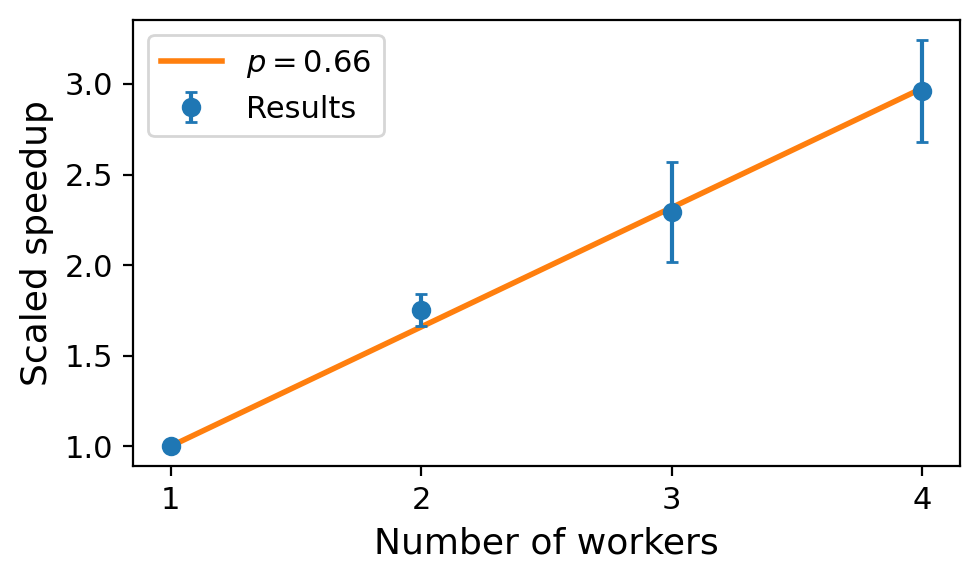

In [18]:
# Get weak scaling for algorithm time:
n_time = [np.array(df['total'] - df['data_input'] - df['first_centroid']) for df in [n1_data, n2_data, n3_data, n4_data]]
speedup_mean = [np.mean((i+1)*n_time[0] / t) for i,t in enumerate(n_time)]
speedup_std = [np.std((i+1)*n_time[0] / t) for i,t in enumerate(n_time)]

# Fit Gustafson's law to our data
opt_res = curve_fit(Gustafson_law, xdata=np.arange(4)+1, ydata=speedup_mean)[0]

# Figure params
FONTSIZE = 13
CS = 2
LW = 2

# Init figure
fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=200)

# Plot results
plt.errorbar(np.arange(4)+1, speedup_mean, yerr=speedup_std, capsize=CS, 
            ls='', marker='o', label='Results')

# Plot fit
plt.plot(np.arange(4)+1, Gustafson_law(np.arange(4)+1, opt_res[0]), lw=LW, 
        label=r'$p=%.2f$' % (opt_res[0]), zorder=-1)

# Labels
plt.xlabel('Number of workers', fontsize=FONTSIZE)
plt.ylabel('Scaled speedup', fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE-2)

# Ticks
plt.xticks(np.arange(4)+1, np.arange(4)+1)

# Legend
plt.legend(fontsize=FONTSIZE-2)

# Show
plt.tight_layout()
plt.show();

From these tests, the parallel fraction of the algorithm appears to be of 66%.

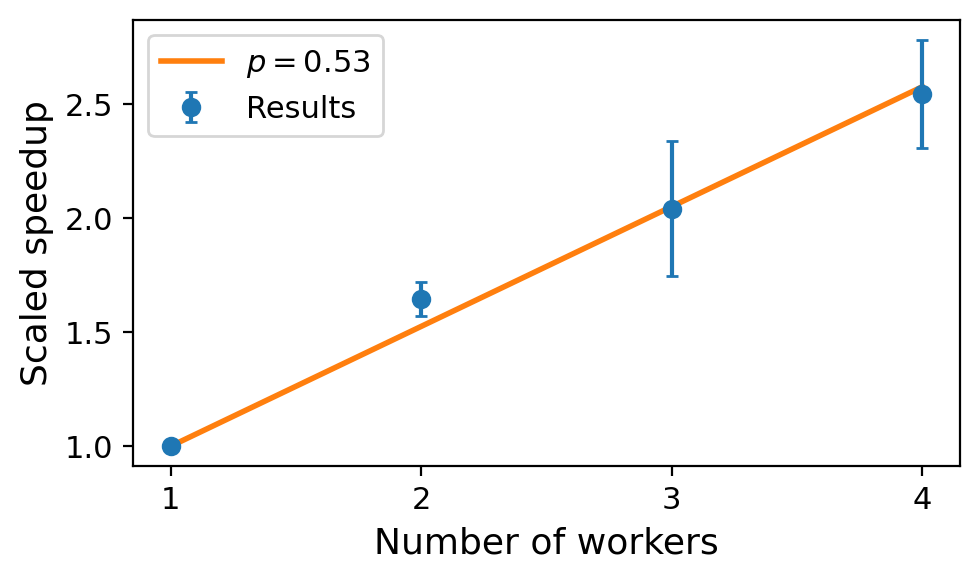

In [19]:
# Let's also get the weak scaling for the total time:
n_time = [np.array(df['total']) for df in [n1_data, n2_data, n3_data, n4_data]]
speedup_mean = [np.mean((i+1)*n_time[0] / t) for i,t in enumerate(n_time)]
speedup_std = [np.std((i+1)*n_time[0] / t) for i,t in enumerate(n_time)]

# Fit Gustafson's law to our data
opt_res = curve_fit(Gustafson_law, xdata=np.arange(4)+1, ydata=speedup_mean)[0]

# Figure params
FONTSIZE = 13
CS = 2
LW = 2

# Init figure
fig, ax = plt.subplots(figsize=(5,3), nrows=1, ncols=1, dpi=200)

# Plot results
plt.errorbar(np.arange(4)+1, speedup_mean, yerr=speedup_std, capsize=CS, 
            ls='', marker='o', label='Results')

# Plot fit
plt.plot(np.arange(4)+1, Gustafson_law(np.arange(4)+1, opt_res[0]), lw=LW, 
        label=r'$p=%.2f$' % (opt_res[0]), zorder=-1)

# Labels
plt.xlabel('Number of workers', fontsize=FONTSIZE)
plt.ylabel('Scaled speedup', fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE-2)

# Ticks
plt.xticks(np.arange(4)+1, np.arange(4)+1)

# Legend
plt.legend(fontsize=FONTSIZE-2)

# Show
plt.tight_layout()
plt.show();

If we include data loading as part of the algorithm, then the estimated parallel fraction drops to 53%.

## Effect of the number of clusters on Kddcup99 dataset

Here, we explore the relationship between the number of clusters to fit, $k$, and the excecution time of our algorithm. To do so, we use the Kddcup99 dataset, which is a standard benchmark dataset for K-Means. This dataset has been previously processed, by removing all non-numerical features.

### Running the algorithm

In [20]:
# K-Means parameters
path_git = 'https://media.githubusercontent.com/media/FrancoAquistapace/Parallel_kmeans_with_Dask/refs/heads/main/kddcup99_num_labeled.csv'
RS = 42
LABEL_COLUMN = 'label'
L = 1 # Oversampling factor
path = './results_k'

#### K = 5

In [25]:
K = 5
N_RUNS = 5

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

# Run
for i in range(N_RUNS):
    print(f'Iteration {i+1} of {N_RUNS}')
    
    # Open cluster
    cluster, client = open_cluster()

    # Run weak scaling algorithm
    res = k_means_parallel(path=path_git, k=K, l=L, label_column=LABEL_COLUMN, 
                           random_seed=RS, verbose=0, npartitions=4)
    # Save results
    for col in stats:
        stats[col].append(res['timing'][col])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path + '_5.csv', index=False)

Iteration 1 of 5


2025-07-07 11:49:10,370 - distributed.deploy.ssh - INFO - 2025-07-07 11:49:10,368 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 11:49:10,398 - distributed.deploy.ssh - INFO - 2025-07-07 11:49:10,397 - distributed.scheduler - INFO - State start
2025-07-07 11:49:10,402 - distributed.deploy.ssh - INFO - 2025-07-07 11:49:10,401 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:35167
2025-07-07 11:49:11,847 - distributed.deploy.ssh - INFO - 2025-07-07 11:49:11,847 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:37257'
2025-07-07 11:49:12,179 - distributed.deploy.ssh - INFO - 2025-07-07 11:49:12,176 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:34443'
2025-07-07 11:49:12,195 - distributed.deploy.ssh - INFO - 2025-07-07 11:49:12,194 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 2 of 5


2025-07-07 11:50:41,529 - distributed.deploy.ssh - INFO - 2025-07-07 11:50:41,528 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 11:50:41,560 - distributed.deploy.ssh - INFO - 2025-07-07 11:50:41,559 - distributed.scheduler - INFO - State start
2025-07-07 11:50:41,565 - distributed.deploy.ssh - INFO - 2025-07-07 11:50:41,564 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:34169
2025-07-07 11:50:43,024 - distributed.deploy.ssh - INFO - 2025-07-07 11:50:43,022 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:41525'
2025-07-07 11:50:43,207 - distributed.deploy.ssh - INFO - 2025-07-07 11:50:43,204 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:46359'
2025-07-07 11:50:43,212 - distributed.deploy.ssh - INFO - 2025-07-07 11:50:43,212 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 3 of 5


2025-07-07 11:51:31,777 - distributed.deploy.ssh - INFO - 2025-07-07 11:51:31,776 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 11:51:31,806 - distributed.deploy.ssh - INFO - 2025-07-07 11:51:31,806 - distributed.scheduler - INFO - State start
2025-07-07 11:51:31,811 - distributed.deploy.ssh - INFO - 2025-07-07 11:51:31,810 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:35999
2025-07-07 11:51:33,224 - distributed.deploy.ssh - INFO - 2025-07-07 11:51:33,221 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:35919'
2025-07-07 11:51:33,236 - distributed.deploy.ssh - INFO - 2025-07-07 11:51:33,236 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126:35921'
2025-07-07 11:51:33,242 - distributed.deploy.ssh - INFO - 2025-07-07 11:51:33,242 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

Iteration 4 of 5


2025-07-07 11:52:21,467 - distributed.deploy.ssh - INFO - 2025-07-07 11:52:21,465 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 11:52:21,496 - distributed.deploy.ssh - INFO - 2025-07-07 11:52:21,495 - distributed.scheduler - INFO - State start
2025-07-07 11:52:21,501 - distributed.deploy.ssh - INFO - 2025-07-07 11:52:21,501 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:41893
2025-07-07 11:52:22,953 - distributed.deploy.ssh - INFO - 2025-07-07 11:52:22,952 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:39923'
2025-07-07 11:52:23,152 - distributed.deploy.ssh - INFO - 2025-07-07 11:52:23,149 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:44087'
2025-07-07 11:52:23,162 - distributed.deploy.ssh - INFO - 2025-07-07 11:52:23,161 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 5 of 5


2025-07-07 11:53:07,639 - distributed.deploy.ssh - INFO - 2025-07-07 11:53:07,639 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 11:53:07,673 - distributed.deploy.ssh - INFO - 2025-07-07 11:53:07,671 - distributed.scheduler - INFO - State start
2025-07-07 11:53:07,675 - distributed.deploy.ssh - INFO - 2025-07-07 11:53:07,675 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:39961
2025-07-07 11:53:09,085 - distributed.deploy.ssh - INFO - 2025-07-07 11:53:09,081 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:34861'
2025-07-07 11:53:09,089 - distributed.deploy.ssh - INFO - 2025-07-07 11:53:09,089 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:33477'
2025-07-07 11:53:09,094 - distributed.deploy.ssh - INFO - 2025-07-07 11:53:09,093 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

#### K = 10

In [21]:
K = 10
N_RUNS = 5

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

# Run
for i in range(N_RUNS):
    print(f'Iteration {i+1} of {N_RUNS}')
    
    # Open cluster
    cluster, client = open_cluster()

    # Run weak scaling algorithm
    res = k_means_parallel(path=path_git, k=K, l=L, label_column=LABEL_COLUMN, 
                           random_seed=RS, verbose=0, npartitions=4)
    # Save results
    for col in stats:
        stats[col].append(res['timing'][col])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path + '_10.csv', index=False)

Iteration 1 of 5


2025-07-07 14:02:53,116 - distributed.deploy.ssh - INFO - 2025-07-07 14:02:53,116 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:02:53,146 - distributed.deploy.ssh - INFO - 2025-07-07 14:02:53,145 - distributed.scheduler - INFO - State start
2025-07-07 14:02:53,151 - distributed.deploy.ssh - INFO - 2025-07-07 14:02:53,151 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:42823
2025-07-07 14:02:54,723 - distributed.deploy.ssh - INFO - 2025-07-07 14:02:54,721 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:42689'
2025-07-07 14:02:54,967 - distributed.deploy.ssh - INFO - 2025-07-07 14:02:54,966 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:36601'
2025-07-07 14:02:54,979 - distributed.deploy.ssh - INFO - 2025-07-07 14:02:54,983 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

Iteration 2 of 5


2025-07-07 14:04:01,632 - distributed.deploy.ssh - INFO - 2025-07-07 14:04:01,632 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:04:01,664 - distributed.deploy.ssh - INFO - 2025-07-07 14:04:01,663 - distributed.scheduler - INFO - State start
2025-07-07 14:04:01,669 - distributed.deploy.ssh - INFO - 2025-07-07 14:04:01,668 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:45581
2025-07-07 14:04:03,121 - distributed.deploy.ssh - INFO - 2025-07-07 14:04:03,120 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:40579'
2025-07-07 14:04:03,322 - distributed.deploy.ssh - INFO - 2025-07-07 14:04:03,320 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:42119'
2025-07-07 14:04:03,326 - distributed.deploy.ssh - INFO - 2025-07-07 14:04:03,329 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

Iteration 3 of 5


2025-07-07 14:05:08,779 - distributed.deploy.ssh - INFO - 2025-07-07 14:05:08,777 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:05:08,806 - distributed.deploy.ssh - INFO - 2025-07-07 14:05:08,806 - distributed.scheduler - INFO - State start
2025-07-07 14:05:08,811 - distributed.deploy.ssh - INFO - 2025-07-07 14:05:08,810 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:44275
2025-07-07 14:05:10,283 - distributed.deploy.ssh - INFO - 2025-07-07 14:05:10,282 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:39871'
2025-07-07 14:05:10,444 - distributed.deploy.ssh - INFO - 2025-07-07 14:05:10,443 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:45853'
2025-07-07 14:05:10,468 - distributed.deploy.ssh - INFO - 2025-07-07 14:05:10,470 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 4 of 5


2025-07-07 14:06:06,947 - distributed.deploy.ssh - INFO - 2025-07-07 14:06:06,945 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:06:06,976 - distributed.deploy.ssh - INFO - 2025-07-07 14:06:06,975 - distributed.scheduler - INFO - State start
2025-07-07 14:06:06,981 - distributed.deploy.ssh - INFO - 2025-07-07 14:06:06,981 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:36707
2025-07-07 14:06:08,382 - distributed.deploy.ssh - INFO - 2025-07-07 14:06:08,381 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:35045'
2025-07-07 14:06:08,394 - distributed.deploy.ssh - INFO - 2025-07-07 14:06:08,395 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126:43033'
2025-07-07 14:06:08,405 - distributed.deploy.ssh - INFO - 2025-07-07 14:06:08,408 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

Iteration 5 of 5


2025-07-07 14:07:04,085 - distributed.deploy.ssh - INFO - 2025-07-07 14:07:04,084 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:07:04,113 - distributed.deploy.ssh - INFO - 2025-07-07 14:07:04,113 - distributed.scheduler - INFO - State start
2025-07-07 14:07:04,118 - distributed.deploy.ssh - INFO - 2025-07-07 14:07:04,118 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:33363
2025-07-07 14:07:05,573 - distributed.deploy.ssh - INFO - 2025-07-07 14:07:05,572 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:44831'
2025-07-07 14:07:05,749 - distributed.deploy.ssh - INFO - 2025-07-07 14:07:05,752 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:45029'
2025-07-07 14:07:05,758 - distributed.deploy.ssh - INFO - 2025-07-07 14:07:05,757 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

#### K = 15

In [23]:
K = 15
N_RUNS = 5

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

# Run
for i in range(N_RUNS):
    print(f'Iteration {i+1} of {N_RUNS}')
    
    # Open cluster
    cluster, client = open_cluster()

    # Run weak scaling algorithm
    res = k_means_parallel(path=path_git, k=K, l=L, label_column=LABEL_COLUMN, 
                           random_seed=RS, verbose=0, npartitions=4)
    # Save results
    for col in stats:
        stats[col].append(res['timing'][col])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path + '_15.csv', index=False)

Iteration 1 of 5


2025-07-07 14:10:25,978 - distributed.deploy.ssh - INFO - 2025-07-07 14:10:25,976 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:10:26,007 - distributed.deploy.ssh - INFO - 2025-07-07 14:10:26,006 - distributed.scheduler - INFO - State start
2025-07-07 14:10:26,012 - distributed.deploy.ssh - INFO - 2025-07-07 14:10:26,012 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38247
2025-07-07 14:10:28,045 - distributed.deploy.ssh - INFO - 2025-07-07 14:10:28,044 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:38829'
2025-07-07 14:10:28,049 - distributed.deploy.ssh - INFO - 2025-07-07 14:10:28,048 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:43383'
2025-07-07 14:10:28,050 - distributed.deploy.ssh - INFO - 2025-07-07 14:10:28,044 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

Iteration 2 of 5


2025-07-07 14:11:28,014 - distributed.deploy.ssh - INFO - 2025-07-07 14:11:28,013 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:11:28,043 - distributed.deploy.ssh - INFO - 2025-07-07 14:11:28,043 - distributed.scheduler - INFO - State start
2025-07-07 14:11:28,048 - distributed.deploy.ssh - INFO - 2025-07-07 14:11:28,048 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:45123
2025-07-07 14:11:29,508 - distributed.deploy.ssh - INFO - 2025-07-07 14:11:29,507 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:33107'
2025-07-07 14:11:29,676 - distributed.deploy.ssh - INFO - 2025-07-07 14:11:29,677 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126:34485'
2025-07-07 14:11:29,694 - distributed.deploy.ssh - INFO - 2025-07-07 14:11:29,692 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

Iteration 3 of 5


2025-07-07 14:12:43,526 - distributed.deploy.ssh - INFO - 2025-07-07 14:12:43,525 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:12:43,555 - distributed.deploy.ssh - INFO - 2025-07-07 14:12:43,554 - distributed.scheduler - INFO - State start
2025-07-07 14:12:43,560 - distributed.deploy.ssh - INFO - 2025-07-07 14:12:43,560 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38043
2025-07-07 14:12:45,045 - distributed.deploy.ssh - INFO - 2025-07-07 14:12:45,044 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:34617'
2025-07-07 14:12:45,223 - distributed.deploy.ssh - INFO - 2025-07-07 14:12:45,222 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:46401'
2025-07-07 14:12:45,243 - distributed.deploy.ssh - INFO - 2025-07-07 14:12:45,243 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 4 of 5


2025-07-07 14:13:24,968 - distributed.deploy.ssh - INFO - 2025-07-07 14:13:24,967 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:13:24,998 - distributed.deploy.ssh - INFO - 2025-07-07 14:13:24,997 - distributed.scheduler - INFO - State start
2025-07-07 14:13:25,003 - distributed.deploy.ssh - INFO - 2025-07-07 14:13:25,002 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:42373
2025-07-07 14:13:26,411 - distributed.deploy.ssh - INFO - 2025-07-07 14:13:26,409 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:37135'
2025-07-07 14:13:26,421 - distributed.deploy.ssh - INFO - 2025-07-07 14:13:26,423 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:39055'
2025-07-07 14:13:26,429 - distributed.deploy.ssh - INFO - 2025-07-07 14:13:26,430 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 5 of 5


2025-07-07 14:14:13,051 - distributed.deploy.ssh - INFO - 2025-07-07 14:14:13,050 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:14:13,079 - distributed.deploy.ssh - INFO - 2025-07-07 14:14:13,079 - distributed.scheduler - INFO - State start
2025-07-07 14:14:13,084 - distributed.deploy.ssh - INFO - 2025-07-07 14:14:13,083 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:44231
2025-07-07 14:14:14,552 - distributed.deploy.ssh - INFO - 2025-07-07 14:14:14,552 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:43667'
2025-07-07 14:14:14,726 - distributed.deploy.ssh - INFO - 2025-07-07 14:14:14,724 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:36621'
2025-07-07 14:14:14,729 - distributed.deploy.ssh - INFO - 2025-07-07 14:14:14,728 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

#### K = 20

In [28]:
K = 20
N_RUNS = 5

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

# Run
for i in range(N_RUNS):
    print(f'Iteration {i+1} of {N_RUNS}')
    
    # Open cluster
    cluster, client = open_cluster()

    # Run weak scaling algorithm
    res = k_means_parallel(path=path_git, k=K, l=L, label_column=LABEL_COLUMN, 
                           random_seed=RS, verbose=0, npartitions=4)
    # Save results
    for col in stats:
        stats[col].append(res['timing'][col])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path + '_20.csv', index=False)

Iteration 1 of 5


2025-07-07 14:18:36,918 - distributed.deploy.ssh - INFO - 2025-07-07 14:18:36,918 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:18:36,948 - distributed.deploy.ssh - INFO - 2025-07-07 14:18:36,947 - distributed.scheduler - INFO - State start
2025-07-07 14:18:36,951 - distributed.deploy.ssh - INFO - 2025-07-07 14:18:36,951 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:37461
2025-07-07 14:18:39,164 - distributed.deploy.ssh - INFO - 2025-07-07 14:18:39,162 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:40415'
2025-07-07 14:18:39,262 - distributed.deploy.ssh - INFO - 2025-07-07 14:18:39,260 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:38937'
2025-07-07 14:18:39,265 - distributed.deploy.ssh - INFO - 2025-07-07 14:18:39,265 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 2 of 5


2025-07-07 14:19:43,563 - distributed.deploy.ssh - INFO - 2025-07-07 14:19:43,563 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:19:43,593 - distributed.deploy.ssh - INFO - 2025-07-07 14:19:43,593 - distributed.scheduler - INFO - State start
2025-07-07 14:19:43,598 - distributed.deploy.ssh - INFO - 2025-07-07 14:19:43,598 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38627
2025-07-07 14:19:45,089 - distributed.deploy.ssh - INFO - 2025-07-07 14:19:45,088 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:43431'
2025-07-07 14:19:45,266 - distributed.deploy.ssh - INFO - 2025-07-07 14:19:45,264 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:44933'
2025-07-07 14:19:45,275 - distributed.deploy.ssh - INFO - 2025-07-07 14:19:45,276 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 3 of 5


2025-07-07 14:20:54,794 - distributed.deploy.ssh - INFO - 2025-07-07 14:20:54,794 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:20:54,825 - distributed.deploy.ssh - INFO - 2025-07-07 14:20:54,824 - distributed.scheduler - INFO - State start
2025-07-07 14:20:54,829 - distributed.deploy.ssh - INFO - 2025-07-07 14:20:54,828 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:42471
2025-07-07 14:20:56,280 - distributed.deploy.ssh - INFO - 2025-07-07 14:20:56,279 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:37293'
2025-07-07 14:20:56,466 - distributed.deploy.ssh - INFO - 2025-07-07 14:20:56,467 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126:33757'
2025-07-07 14:20:56,471 - distributed.deploy.ssh - INFO - 2025-07-07 14:20:56,472 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.10

Iteration 4 of 5


2025-07-07 14:21:50,314 - distributed.deploy.ssh - INFO - 2025-07-07 14:21:50,312 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:21:50,342 - distributed.deploy.ssh - INFO - 2025-07-07 14:21:50,342 - distributed.scheduler - INFO - State start
2025-07-07 14:21:50,347 - distributed.deploy.ssh - INFO - 2025-07-07 14:21:50,346 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:35035
2025-07-07 14:21:51,747 - distributed.deploy.ssh - INFO - 2025-07-07 14:21:51,744 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:46137'
2025-07-07 14:21:51,762 - distributed.deploy.ssh - INFO - 2025-07-07 14:21:51,765 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:35683'
2025-07-07 14:21:51,768 - distributed.deploy.ssh - INFO - 2025-07-07 14:21:51,769 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 5 of 5


2025-07-07 14:22:57,326 - distributed.deploy.ssh - INFO - 2025-07-07 14:22:57,325 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:22:57,356 - distributed.deploy.ssh - INFO - 2025-07-07 14:22:57,355 - distributed.scheduler - INFO - State start
2025-07-07 14:22:57,360 - distributed.deploy.ssh - INFO - 2025-07-07 14:22:57,359 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:38695
2025-07-07 14:22:58,833 - distributed.deploy.ssh - INFO - 2025-07-07 14:22:58,832 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:37343'
2025-07-07 14:22:59,006 - distributed.deploy.ssh - INFO - 2025-07-07 14:22:59,003 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:42535'
2025-07-07 14:22:59,011 - distributed.deploy.ssh - INFO - 2025-07-07 14:22:59,013 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

#### K = 25

In [31]:
K = 25
N_RUNS = 5

# Init stats
stats = {'total': [], 'data_input': [], 'data_processing': [], 'first_centroid': [],
         'xxt': [], 'phi_init': [], 'parallel_init': [], 'weight_calc': [], 
         'lloyd': [], 'final_labels': []}

# Run
for i in range(N_RUNS):
    print(f'Iteration {i+1} of {N_RUNS}')
    
    # Open cluster
    cluster, client = open_cluster()

    # Run weak scaling algorithm
    res = k_means_parallel(path=path_git, k=K, l=L, label_column=LABEL_COLUMN, 
                           random_seed=RS, verbose=0, npartitions=4)
    # Save results
    for col in stats:
        stats[col].append(res['timing'][col])
    
    # Close cluster
    close_cluster(cluster, client)

# Save results
stats = pd.DataFrame(stats)
stats.to_csv(path + '_25.csv', index=False)

Iteration 1 of 5


2025-07-07 14:25:57,337 - distributed.deploy.ssh - INFO - 2025-07-07 14:25:57,336 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:25:57,367 - distributed.deploy.ssh - INFO - 2025-07-07 14:25:57,366 - distributed.scheduler - INFO - State start
2025-07-07 14:25:57,373 - distributed.deploy.ssh - INFO - 2025-07-07 14:25:57,372 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:33639
2025-07-07 14:25:58,837 - distributed.deploy.ssh - INFO - 2025-07-07 14:25:58,835 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:45809'
2025-07-07 14:25:59,479 - distributed.deploy.ssh - INFO - 2025-07-07 14:25:59,476 - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.240:36385
2025-07-07 14:25:59,898 - distributed.deploy.ssh - INFO - 2025-07-07 14:25:59,899 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.12

Iteration 2 of 5


2025-07-07 14:27:12,505 - distributed.deploy.ssh - INFO - 2025-07-07 14:27:12,505 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:27:12,535 - distributed.deploy.ssh - INFO - 2025-07-07 14:27:12,534 - distributed.scheduler - INFO - State start
2025-07-07 14:27:12,540 - distributed.deploy.ssh - INFO - 2025-07-07 14:27:12,539 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:33771
2025-07-07 14:27:13,998 - distributed.deploy.ssh - INFO - 2025-07-07 14:27:13,998 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:33895'
2025-07-07 14:27:14,183 - distributed.deploy.ssh - INFO - 2025-07-07 14:27:14,184 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:36225'
2025-07-07 14:27:14,187 - distributed.deploy.ssh - INFO - 2025-07-07 14:27:14,181 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17

Iteration 3 of 5


2025-07-07 14:28:15,917 - distributed.deploy.ssh - INFO - 2025-07-07 14:28:15,915 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:28:15,944 - distributed.deploy.ssh - INFO - 2025-07-07 14:28:15,943 - distributed.scheduler - INFO - State start
2025-07-07 14:28:15,949 - distributed.deploy.ssh - INFO - 2025-07-07 14:28:15,948 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:45063
2025-07-07 14:28:17,434 - distributed.deploy.ssh - INFO - 2025-07-07 14:28:17,433 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:37549'
2025-07-07 14:28:17,622 - distributed.deploy.ssh - INFO - 2025-07-07 14:28:17,617 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:38377'
2025-07-07 14:28:17,624 - distributed.deploy.ssh - INFO - 2025-07-07 14:28:17,625 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 4 of 5


2025-07-07 14:29:16,034 - distributed.deploy.ssh - INFO - 2025-07-07 14:29:16,034 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:29:16,064 - distributed.deploy.ssh - INFO - 2025-07-07 14:29:16,063 - distributed.scheduler - INFO - State start
2025-07-07 14:29:16,070 - distributed.deploy.ssh - INFO - 2025-07-07 14:29:16,069 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:34311
2025-07-07 14:29:17,488 - distributed.deploy.ssh - INFO - 2025-07-07 14:29:17,484 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:40821'
2025-07-07 14:29:17,497 - distributed.deploy.ssh - INFO - 2025-07-07 14:29:17,498 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100:36927'
2025-07-07 14:29:17,501 - distributed.deploy.ssh - INFO - 2025-07-07 14:29:17,502 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.126

Iteration 5 of 5


2025-07-07 14:30:09,335 - distributed.deploy.ssh - INFO - 2025-07-07 14:30:09,334 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-07 14:30:09,363 - distributed.deploy.ssh - INFO - 2025-07-07 14:30:09,363 - distributed.scheduler - INFO - State start
2025-07-07 14:30:09,368 - distributed.deploy.ssh - INFO - 2025-07-07 14:30:09,368 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.240:33429
2025-07-07 14:30:10,848 - distributed.deploy.ssh - INFO - 2025-07-07 14:30:10,846 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.240:42829'
2025-07-07 14:30:11,014 - distributed.deploy.ssh - INFO - 2025-07-07 14:30:11,011 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.17:38107'
2025-07-07 14:30:11,050 - distributed.deploy.ssh - INFO - 2025-07-07 14:30:11,050 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.100

### Analysing the results

In [20]:
# Read our resulting data
k_5_df = pd.read_csv('./results_k_5.csv')
k_10_df = pd.read_csv('./results_k_10.csv')
k_15_df = pd.read_csv('./results_k_15.csv')
k_20_df = pd.read_csv('./results_k_20.csv')
k_25_df = pd.read_csv('./results_k_25.csv')

In [21]:
def linear_f(k, a, b):
    return k*a + b

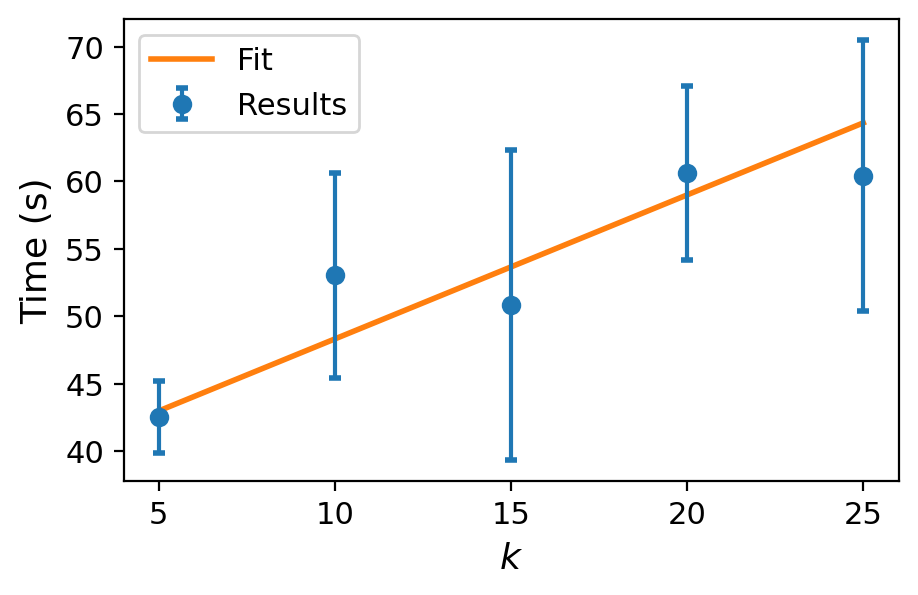

In [22]:
# Process our results
k_values = [5, 10, 15, 20, 25]
mean_algorithm_t = [np.mean(df['total'] - df['data_input'] - df['first_centroid'])\
                    for df in [k_5_df, k_10_df, k_15_df, k_20_df, k_25_df]]
std_algorithm_t = [np.std(df['total'] - df['data_input'] - df['first_centroid'])\
                    for df in [k_5_df, k_10_df, k_15_df, k_20_df, k_25_df]]

# Fit linear model
opt_res = curve_fit(linear_f, xdata=k_values, ydata=mean_algorithm_t, sigma=std_algorithm_t)[0]

# Figure params
FONTSIZE = 13
CS = 2
LW = 2

# Init figure
fig, ax = plt.subplots(figsize=(5, 3), nrows=1, ncols=1, dpi=200)

# Plot data
plt.errorbar(k_values, mean_algorithm_t, yerr=std_algorithm_t, marker='o', 
            ls='', capsize=CS, capthick=LW, label='Results')

# Plot linear fit
plt.plot(k_values, linear_f(np.array(k_values), opt_res[0], opt_res[1]), 
        lw=LW, label='Fit', zorder=-1)

# X-ticks
plt.xticks(k_values, k_values)

# Labels
plt.ylabel('Time (s)', fontsize=FONTSIZE)
plt.xlabel(r'$k$', fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE-2)

# Legend
plt.legend(fontsize=FONTSIZE-2)

# Show
plt.show();

In [23]:
# Let's try to estimate the time required for a large amount of clusters
print(f'Estimated time for k=500: ~{round(linear_f(500, opt_res[0], opt_res[1]) / 60)} minutes')

Estimated time for k=500: ~10 minutes


In [24]:
# Let's also show what is the expected increase in time per added cluster
print(f'Time increase per additional cluster: {round(opt_res[0], 1)} s')

Time increase per additional cluster: 1.1 s
